In [1]:
%tensorflow_version 1.x
from google.colab import files

TensorFlow 1.x selected.


In [0]:
# Install Kaggle library
!pip install -q kaggle

In [3]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!cp kaggle.json ~/.kaggle/

In [12]:
!kaggle datasets download -d emmarex/plantdisease

 96% 634M/658M [00:19<00:01, 15.2MB/s]
100% 658M/658M [00:19<00:00, 34.8MB/s]


In [0]:
%%capture
!unzip plantdisease.zip

In [14]:
!ls

kaggle.json  plantdisease.zip  plantvillage  PlantVillage  sample_data


In [15]:
!ls PlantVillage

Pepper__bell___Bacterial_spot  Tomato_Late_blight
Pepper__bell___healthy	       Tomato_Leaf_Mold
Potato___Early_blight	       Tomato_Septoria_leaf_spot
Potato___healthy	       Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Late_blight	       Tomato__Target_Spot
Tomato_Bacterial_spot	       Tomato__Tomato_mosaic_virus
Tomato_Early_blight	       Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_healthy


In [16]:
!ls plantvillage

PlantVillage


In [17]:
import os
folders = os.listdir("PlantVillage")
print(folders)

['Tomato_healthy', 'Tomato__Tomato_mosaic_virus', 'Potato___Early_blight', 'Tomato_Leaf_Mold', 'Tomato_Early_blight', 'Pepper__bell___healthy', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Potato___Late_blight', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite']


In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1.0/255)

train_generator = train_gen.flow_from_directory("PlantVillage", target_size = (224,224), batch_size = 64, class_mode = "categorical", shuffle = True)


Using TensorFlow backend.


Found 20638 images belonging to 15 classes.


# New Section

In [19]:
train_generator.labels

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int32)

In [20]:
x, y = train_generator.next()
print(x.shape)
print(y.shape)

(64, 224, 224, 3)
(64, 15)


In [0]:
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Model

In [22]:
model = ResNet50(include_top =False, weights = "imagenet", input_shape = (224,224,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


In [23]:
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256 , activation = "relu")(av1)
d1 = Dropout(0.4)(fc1)
fc2 = Dense(15 , activation= "softmax")(d1)

model_new = Model(input = model.input, output = fc2)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [24]:
adam = Adam(lr = 0.00003)
model_new.compile(loss = "categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"] )

In [0]:
for ix in range(169):
    model_new.layers[ix].trainable = False
model_new.compile(loss = "categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"] )


In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import keras

class PlotLearning(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

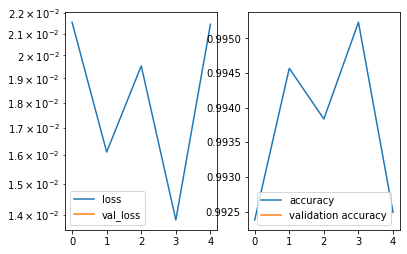

model weights are save on disk


In [37]:
plot = PlotLearning()

hist = model_new.fit_generator(train_generator, epochs = 5, steps_per_epoch= 325, callbacks=[plot])

model_new.save("CropAI_model_train_gen_epoch_5.h5")
print("model weights are save on disk")